## Amplitude demodulation 

This notebook will walk through the process of [Quadrature Amplitude Demodulation](https://pysdr.org/content/sampling.html#quadrature-sampling) that we use in the NSP2 to measure the amplitudes of the two LED wavelengths that
are simultaneously transmitted through the tissue.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.signal as si
from scipy.fft import fft, fftfreq
from rich.jupyter import print

In [2]:
F0 = 46875.0 # Sampling rate of the NSP2 DAQ [Herz]

def square(t, carrierfreq):
    """
    Create a square wave with samples at timepoints t and frequency carrierfreq
    """
    return si.square(2 * np.pi * t * carrierfreq)

def sine(t, carrierfreq):
    """
    Create a sine wave with samples at timepoints t and frequency carrierfreq
    """
    return np.sin(2 * np.pi * t * carrierfreq)

In [3]:
dacbuflen = 96 # Number of samples of the DAC buffer
def carrier_freq(period_count, sample_count=dacbuflen):
    """
    Calculates the frequency of a signal that has period_count
    periods within sample_count samples sampled with frequency F0
    """

    return period_count * F0 / sample_count

We create to sine waves with two different modulation frequencies

In [4]:
nsamples = 192 # 
# Time points where the ADC samples the signal
t = np.arange(nsamples)/F0
# Two signals with different amplitudes
signal1 = sine(t, carrier_freq(6)) * 0.4
signal2 = sine(t, carrier_freq(8)) * 0.6
# The transmitted/detected signal is the sum of the two!
signal = signal1 + signal2

Let's have a look how the signal looks like. This assumes there are no distortions in the signal path.

Text(0.5, 0, 'Time [ms]')

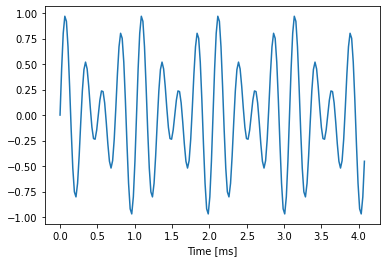

In [5]:
plt.plot(t * 1000,signal)
plt.xlabel("Time [ms]")

Let's define our demodulation function first. This is a digital QAM demodulator. We extract the I(t) and Q(t) components by multiplying with sine and cosine waves of the carrier frequency.

In [6]:
def demodulate(t, signal, carrierfreq):
    """
    Extract the amplitude of a carrier frequency in a HF signal
    Inputs:
        t: array of times when the signal was sampled [seconds]
        signal: array of sample values
        carrierfreq: frequency [Hz] of the carrier frequency that we want to demodulate
        window: Window function to apply to the signal
    Output:
        Amplitude of the carrier frequency in the signal
    """
    # Multiply each sample value in the signal with the corresponding
    # value in a pure sine wave corresponding to the carrier frequency 
    sigsin = signal * np.sin(2. * np.pi * carrierfreq * t)
    # Do the same with a cosine (sine shifted by 90 degrees in phase)
    sigcos = signal * np.cos(2. * np.pi * carrierfreq * t)
    # Average the multiplied samples (= lowpass filter)
    ssin = sigsin.sum() / len(sigsin)
    scos = sigcos.sum() / len(sigcos)
    # Amplitude is 2 * sqrt(ssin^2 + scos^2)
    amplitude = 2. * np.sqrt( ssin * ssin + scos * scos)
    return amplitude

No we can try to demodulate a number of possible frequencies and check what we get:

In [7]:
scale_factor = 1
for periods in (5,6,7,8,9,10,11,12):
    demod_amp = demodulate(t, signal, carrier_freq(periods))
    demod_amp *= scale_factor
    print(f"Periods: {periods} = Frequency: {carrier_freq(periods):.2f} Hz:   Demodulated amplitude: {demod_amp:.3f}")

Periods: 5 = Frequency: 2441.41 Hz:   Demodulated amplitude: 0.000

Periods: 6 = Frequency: 2929.69 Hz:   Demodulated amplitude: 0.400

Periods: 7 = Frequency: 3417.97 Hz:   Demodulated amplitude: 0.000

Periods: 8 = Frequency: 3906.25 Hz:   Demodulated amplitude: 0.600

Periods: 9 = Frequency: 4394.53 Hz:   Demodulated amplitude: 0.000

Periods: 10 = Frequency: 4882.81 Hz:   Demodulated amplitude: 0.000

Periods: 11 = Frequency: 5371.09 Hz:   Demodulated amplitude: 0.000

Periods: 12 = Frequency: 5859.38 Hz:   Demodulated amplitude: 0.000

We recovered excactly the amplitudes that we put in into the carrier frequencies and no signal at all in any of the other frequencies!

Let's try to be a bit more realistic. We are simulating a limited frequency response of the detectors, amplifiers etc. by low-pass filtering the signal. We are also adding some noise to the signal.

In [8]:
mu, sigma = 0, 0.05
noise1 = np.random.normal(mu, sigma, len(signal))
noise2 = np.random.normal(mu, sigma, len(signal))
b, a, = si.butter(N=2, Wn=15000, btype="lowpass", fs=46875)
filtered = si.lfilter(b, a, signal + noise1) + noise2

Let's look at the signal again:

Text(0.5, 0, 'Time [ms]')

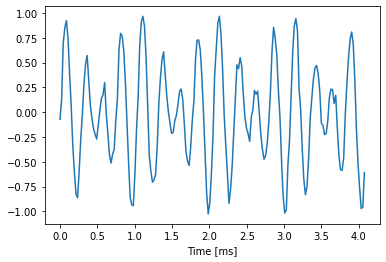

In [9]:
plt.plot(t * 1000, filtered)
plt.xlabel("Time [ms]")

And let's demodulate the signal again. Due to the added noise and the finite frequency-response, we get some noise into our demodulated signal and also (small) demodulated signals in other frequencies. 

In [10]:
for periods in (5,6,7,8,9,10,11,12):
    demod_amp = demodulate(t, filtered, carrier_freq(periods))
    demod_amp *= scale_factor
    print(f"Periods: {periods} = Frequency: {carrier_freq(periods):.2f} Hz:   Demodulated amplitude: {demod_amp:.3f}")

Periods: 5 = Frequency: 2441.41 Hz:   Demodulated amplitude: 0.010

Periods: 6 = Frequency: 2929.69 Hz:   Demodulated amplitude: 0.396

Periods: 7 = Frequency: 3417.97 Hz:   Demodulated amplitude: 0.006

Periods: 8 = Frequency: 3906.25 Hz:   Demodulated amplitude: 0.594

Periods: 9 = Frequency: 4394.53 Hz:   Demodulated amplitude: 0.005

Periods: 10 = Frequency: 4882.81 Hz:   Demodulated amplitude: 0.011

Periods: 11 = Frequency: 5371.09 Hz:   Demodulated amplitude: 0.010

Periods: 12 = Frequency: 5859.38 Hz:   Demodulated amplitude: 0.005

Let's move on to square wave/rectangular modulation. To start, we have a look at the Fourier coefficients of a square wave signal and a sine wave.

Text(0.5, 0, 'Frequency [Hz]')

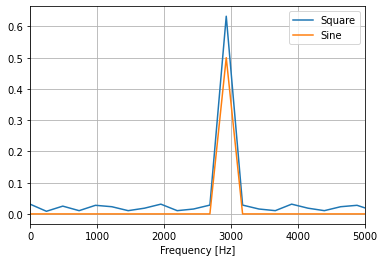

In [11]:
rect_signal = square(t, carrier_freq(6)) * 0.5
sine_signal = sine(t, carrier_freq(6)) * 0.5
dt = 1.0 / F0
yf_rect = fft(rect_signal)
yf_sine = fft(sine_signal)
xf = fftfreq(nsamples, dt)[:nsamples//2]

plt.plot(xf, 2.0/nsamples * np.abs(yf_rect[0:nsamples//2]), label="Square")
plt.plot(xf, 2.0/nsamples * np.abs(yf_sine[0:nsamples//2]), label="Sine")
plt.grid()
plt.legend()
plt.xlim(0,5000)
plt.xlabel("Frequency [Hz]")

What we found out here is that amplitude of the base frequency in a square wave is $4/\pi$ times bigger than in a sine wave with the same amplitude and frequency. This will become important in a moment.

Let's create again two signal (this time square) and add them up.

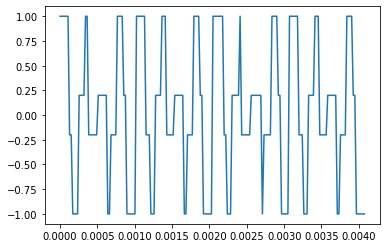

In [12]:
signal1 = square(t, carrier_freq(6)) * 0.4
signal2 = square(t, carrier_freq(8)) * 0.6
# The transmitted/detected signal is the sum of the two!
signal = signal1 + signal2

plt.plot(t, signal)

... and try to demodulate the signal.

In [13]:
# The scale factor necessary because of the different power in the base frequency compared to a sine wave.
scale_factor = np.pi/4
for periods in (5,6,7,8,9,10,11,12):
    demod_amp = demodulate(t, signal, carrier_freq(periods))
    demod_amp *= scale_factor
    print(f"Periods: {periods} = Frequency: {carrier_freq(periods):.2f} Hz:   Demodulated amplitude: {demod_amp:.3f}")

Periods: 5 = Frequency: 2441.41 Hz:   Demodulated amplitude: 0.043

Periods: 6 = Frequency: 2929.69 Hz:   Demodulated amplitude: 0.396

Periods: 7 = Frequency: 3417.97 Hz:   Demodulated amplitude: 0.026

Periods: 8 = Frequency: 3906.25 Hz:   Demodulated amplitude: 0.576

Periods: 9 = Frequency: 4394.53 Hz:   Demodulated amplitude: 0.025

Periods: 10 = Frequency: 4882.81 Hz:   Demodulated amplitude: 0.023

Periods: 11 = Frequency: 5371.09 Hz:   Demodulated amplitude: 0.054

Periods: 12 = Frequency: 5859.38 Hz:   Demodulated amplitude: 0.031

The result is not as clean as in the case of sine waves. This is mainly due to the finite number of samples we demodulate. Basically we introduced a square wave with another frequency by cutting of the signal at both ends. That square wave will also have frequency components in our desired carrier frequency.

Let's also have a look at what happens when we introduce noise and a limited bandwidth to our signal.

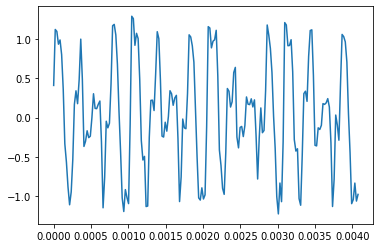

In [14]:
signal1 = square(t, carrier_freq(6)) * 0.4
signal2 = square(t, carrier_freq(8)) * 0.6
signal = signal1 + signal2

mu, sigma = 0, 0.05
noise1 = np.random.normal(mu, sigma, len(signal))
noise2 = np.random.normal(mu, sigma, len(signal))
b, a, = si.butter(N=2, Wn=15000, btype="lowpass", fs=46875)
filtered = si.lfilter(b, a, signal + noise1) + noise2
plt.plot(t, filtered)

This is actually roughly how the raw signal from the NSP2 looks like, when using square wave modulation!
Let's try to demodulate the signal.

In [15]:
scale_factor = np.pi/4
for periods in (5,6,7,8,9,10,11,12):
    demod_amp = demodulate(t, signal, carrier_freq(periods))
    demod_amp *= scale_factor
    print(f"Periods: {periods} = Frequency: {carrier_freq(periods):.2f} Hz:   Demodulated amplitude: {demod_amp:.3f}")

Periods: 5 = Frequency: 2441.41 Hz:   Demodulated amplitude: 0.043

Periods: 6 = Frequency: 2929.69 Hz:   Demodulated amplitude: 0.396

Periods: 7 = Frequency: 3417.97 Hz:   Demodulated amplitude: 0.026

Periods: 8 = Frequency: 3906.25 Hz:   Demodulated amplitude: 0.576

Periods: 9 = Frequency: 4394.53 Hz:   Demodulated amplitude: 0.025

Periods: 10 = Frequency: 4882.81 Hz:   Demodulated amplitude: 0.023

Periods: 11 = Frequency: 5371.09 Hz:   Demodulated amplitude: 0.054

Periods: 12 = Frequency: 5859.38 Hz:   Demodulated amplitude: 0.031

Still we manage to recover the original amplitudes! By playing with the amplitudes of signal1 and signal2 above, you can verify that there is very little cross-talk between the signals.